In [10]:
# 1. Install and Import Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import warnings
from tqdm import tqdm

# Darts
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import rmse, mape
from darts.models import (
    ExponentialSmoothing,
    AutoARIMA,
    Prophet,
    TiDEModel,
    NBEATSModel,
    TFTModel
)

# Suppress warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger("darts").setLevel(logging.WARNING)

print("Libraries imported.")

Libraries imported.


In [11]:
# Check availability of specific models
try:
    from darts.models import AutoARIMA
    print("AutoARIMA available.")
except ImportError:
    print("AutoARIMA NOT available.")

try:
    from darts.models import Prophet
    print("Prophet available.")
except ImportError:
    print("Prophet NOT available (install 'prophet' or 'fbprophet').")


AutoARIMA available.
Prophet available.


Dataset: Kaggle BTC/USD Hourly
Full series duration: 2012-01-01 10:00:00 to 2025-12-21 23:00:00 (122486 points)
Training set duration: 2012-01-01 10:00:00 to 2025-12-14 23:00:00 (122318 points)
Test set duration: 2025-12-15 00:00:00 to 2025-12-21 23:00:00 (168 points)
Seasonal period: 24


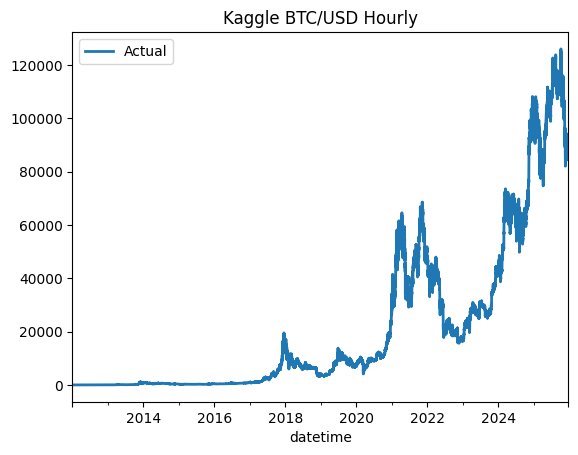

In [12]:
# 2. Load and Preprocess Data

# ============================================================================
# DATASET CONFIGURATION - CHANGE THESE VALUES FOR DIFFERENT DATASETS
# ============================================================================
DATASET_CONFIG = {
    # Dataset file path (relative to this notebook)
    'file_path': '../datasets/kaggle_btcusd_hourly.csv',
    
    # Column names
    'time_column': 'datetime',      # Name of the datetime column
    'target_column': 'btc_usd',      # Name of the target variable column
    
    # Time series frequency and test split
    'frequency': 'H',               # 'MS'=monthly, 'QS'=quarterly, 'YS'=yearly, 'H'=hourly, 'D'=daily
    'test_periods': 168,              # Number of periods to reserve for testing
    'seasonal_period': 24,           # Seasonal period (12=monthly, 4=quarterly, 1=yearly, 24=hourly, 7=daily)
    
    # Dataset name for plots
    'name': 'Kaggle BTC/USD Hourly'
}

# ============================================================================
# AVAILABLE DATASET CONFIGURATIONS (uncomment to use)
# ============================================================================
# DATASET_CONFIG = {
#     'file_path': '../datasets/wb_usa_real_gdp_yearly.csv',
#     'time_column': 'timestamp', 'target_column': 'real_gdp',
#     'frequency': 'YS', 'test_periods': 10, 'seasonal_period': 1,
#     'name': 'World Bank USA Real GDP Yearly'
# }

# DATASET_CONFIG = {
#     'file_path': '../datasets/fred_gpdic1_investments_quarterly.csv',
#     'time_column': 'timestamp', 'target_column': 'gpdic1',
#     'frequency': 'QS', 'test_periods': 8, 'seasonal_period': 4,
#     'name': 'FRED GPDIC1 Investments Quarterly'
# }

# DATASET_CONFIG = {
#     'file_path': '../datasets/m5_walmart_hobbies_daily.csv',
#     'time_column': 'timestamp', 'target_column': 'sales',
#     'frequency': 'D', 'test_periods': 28, 'seasonal_period': 7,
#     'name': 'M5 Walmart Hobbies Daily'
# }

# DATASET_CONFIG = {
#     'file_path': '../datasets/kaggle_btcusd_hourly.csv',
#     'time_column': 'datetime', 'target_column': 'btc_usd',
#     'frequency': 'H', 'test_periods': 168, 'seasonal_period': 24,  # 168 = 7 days
#     'name': 'Kaggle BTC/USD Hourly'
# }

# ============================================================================
# LOAD AND PREPROCESS DATA (no changes needed below)
# ============================================================================
df = pd.read_csv(DATASET_CONFIG['file_path'])
df[DATASET_CONFIG['time_column']] = pd.to_datetime(df[DATASET_CONFIG['time_column']])
series = TimeSeries.from_dataframe(df, DATASET_CONFIG['time_column'], DATASET_CONFIG['target_column'])

# Cast to float32 for MPS/DL compatibility
series = series.astype(np.float32)

# Split Train/Test based on frequency
freq = DATASET_CONFIG['frequency']
test_periods = DATASET_CONFIG['test_periods']

if freq == 'MS':
    offset = pd.DateOffset(months=test_periods)
elif freq == 'QS':
    offset = pd.DateOffset(months=test_periods * 3)
elif freq == 'YS':
    offset = pd.DateOffset(years=test_periods)
elif freq == 'D':
    offset = pd.DateOffset(days=test_periods)
elif freq == 'H':
    offset = pd.DateOffset(hours=test_periods)
else:
    offset = pd.DateOffset(days=test_periods)

train, test = series.split_after(pd.Timestamp(series.end_time()) - offset)

# Scaler for DL models
scaler = Scaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)
series_scaled = scaler.transform(series)

print(f"Dataset: {DATASET_CONFIG['name']}")
print(f"Full series duration: {series.start_time()} to {series.end_time()} ({len(series)} points)")
print(f"Training set duration: {train.start_time()} to {train.end_time()} ({len(train)} points)")
print(f"Test set duration: {test.start_time()} to {test.end_time()} ({len(test)} points)")
print(f"Seasonal period: {DATASET_CONFIG['seasonal_period']}")

series.plot(label='Actual')
plt.title(DATASET_CONFIG['name'])
plt.show()

In [13]:
# 3. Define Evaluation Metrics and Logging

results = []

def log_result(model_name, rmse_val, mape_val, tuning_time, best_config_time, params=None, n_combinations=1):
    """
    Log model results with comprehensive timing information.
    
    Args:
        tuning_time: Total time for hyperparameter tuning (all combinations + CV)
        best_config_time: Time for the best configuration only (training + CV)
        n_combinations: Number of parameter combinations evaluated
    """
    results.append({
        'Model': model_name,
        'RMSE': rmse_val,
        'MAPE': mape_val,
        'Tuning Time (s)': tuning_time,        # Total tuning time (all combinations)
        'Best Config Time (s)': best_config_time,  # Time for best params only
        'Combinations': n_combinations,
        'Params': params
    })
    print(f"Logged: {model_name} | RMSE: {rmse_val:.4f} | MAPE: {mape_val:.2f}% | "
          f"Tuning: {tuning_time:.2f}s ({n_combinations} combos) | Best config: {best_config_time:.2f}s")

def get_results_df():
    return pd.DataFrame(results).sort_values(by='RMSE')

In [14]:
# 4. Define Hyperparameter Tuning Strategy (Grid/Random Search) & Cross Validation

# SET GLOBAL SEED FOR REPRODUCIBILITY
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ============================================================================
# PERFORMANCE SETTINGS FOR LARGE DATASETS
# ============================================================================
# Maximum number of training points for CV (subsample if larger)
MAX_TRAIN_POINTS_FOR_CV = 5000  # Reduce for faster tuning on large datasets

# Stride multiplier for CV (higher = faster but less thorough)
# For hourly data with seasonal_period=24, stride=24 means evaluate once per day
CV_STRIDE_MULTIPLIER = 1  # stride = seasonal_period * this multiplier

def grid_search_all(param_grid):
    """
    Generates ALL combinations from the parameter grid (full grid search).
    Use this for reproducible scientific research.
    """
    from itertools import product
    
    if not param_grid:
        return [{}]
    
    keys = list(param_grid.keys())
    values = list(param_grid.values())
    
    combinations = []
    for combo in product(*values):
        params = dict(zip(keys, combo))
        combinations.append(params)
    
    return combinations

def random_grid_search(param_grid, n_iter=5, seed=RANDOM_SEED):
    """
    Generates a list of random parameter combinations from the grid.
    Uses fixed seed for reproducibility.
    """
    rng = random.Random(seed)  # Local RNG with fixed seed
    keys = list(param_grid.keys())
    
    if not keys:
        return [{}]

    combinations = []
    for _ in range(n_iter):
        params = {}
        for key in keys:
            params[key] = rng.choice(param_grid[key])
        combinations.append(params)
    
    # Remove duplicates while preserving order
    seen = set()
    unique_combinations = []
    for d in combinations:
        key = frozenset((k, str(v)) for k, v in d.items())
        if key not in seen:
            seen.add(key)
            unique_combinations.append(d)
    
    return unique_combinations

def subsample_series(series, max_points):
    """Subsample a time series to max_points, keeping the most recent data."""
    if len(series) <= max_points:
        return series
    # Keep the most recent max_points
    return series[-max_points:]

def evaluate_model(model_cls, params, series_train, series_val, is_dl=False, forecast_horizon=12, stride=1, scaler=None, original_series=None):
    """
    Evaluates a model using rolling window cross-validation (historical_forecasts).
    Returns: (rmse_score, mape_score, duration)
    
    For large datasets, uses subsampling to speed up evaluation.
    """
    start_time = time.time()
    
    try:
        model = model_cls(**params)
        
        # Subsample for faster CV on large datasets (only for statistical models)
        if not is_dl and len(series_train) > MAX_TRAIN_POINTS_FOR_CV:
            cv_series = subsample_series(series_train, MAX_TRAIN_POINTS_FOR_CV)
            print(f"  [Subsampled {len(series_train)} → {len(cv_series)} points for CV]", end="")
        else:
            cv_series = series_train
        
        # Use larger stride for faster CV
        cv_stride = max(stride, DATASET_CONFIG['seasonal_period'] * CV_STRIDE_MULTIPLIER)
        
        if is_dl:
            model.fit(series_train, verbose=False)
            backtest_series = model.historical_forecasts(
                series=series_train,
                start=0.7,
                forecast_horizon=forecast_horizon,
                stride=cv_stride,
                retrain=False,
                verbose=False,
                last_points_only=True
            )
        else:
            backtest_series = model.historical_forecasts(
                series=cv_series,
                start=0.7,
                forecast_horizon=forecast_horizon,
                stride=cv_stride,
                retrain=True, 
                verbose=False,
                last_points_only=True
            )
            
        # Inverse transform if scaler provided
        if scaler:
            backtest_series = scaler.inverse_transform(backtest_series)
            if original_series:
                actual_series = original_series
            else:
                actual_series = scaler.inverse_transform(series_train)
        else:
            actual_series = cv_series if not is_dl else series_train

        # Calculate metrics
        rmse_score = rmse(actual_series, backtest_series)
        mape_score = mape(actual_series, backtest_series)
        
        end_time = time.time()
        return rmse_score, mape_score, end_time - start_time
        
    except Exception as e:
        try:
            model_name = model_cls.__name__
        except:
            model_name = str(model_cls)
            
        print(f"Error evaluating {model_name} with params {params}: {e}")
        return float('inf'), float('inf'), 0

def run_tuning_and_eval(model_name, model_cls, param_grid, train_series, is_dl=False, 
                        n_iter=5, scaler=None, original_series=None, use_full_grid=False):
    """
    Run hyperparameter tuning with either full grid search or random search.
    Measures TOTAL tuning time (all combinations) for fair comparison.
    """
    print(f"--- Tuning {model_name} ---")
    print(f"Training data: {len(train_series)} points | Max CV points: {MAX_TRAIN_POINTS_FOR_CV} | CV stride: {DATASET_CONFIG['seasonal_period'] * CV_STRIDE_MULTIPLIER}")
    
    # Start timing the ENTIRE tuning process
    tuning_start_time = time.time()
    
    if not param_grid:
        # No tuning, just run default
        best_params = {}
        rmse_val, mape_val, config_time = evaluate_model(model_cls, {}, train_series, None, is_dl=is_dl, scaler=scaler, original_series=original_series)
        tuning_total_time = time.time() - tuning_start_time
        if rmse_val != float('inf'):
            log_result(model_name, rmse_val, mape_val, tuning_total_time, config_time, best_params, n_combinations=1)
        return best_params
    
    # Choose search strategy
    if use_full_grid:
        combinations = grid_search_all(param_grid)
        print(f"Full grid search: {len(combinations)} combinations")
    else:
        combinations = random_grid_search(param_grid, n_iter=n_iter, seed=RANDOM_SEED)
        print(f"Random search (seed={RANDOM_SEED}): {len(combinations)} combinations")
    
    best_rmse = float('inf')
    best_params = None
    best_config_time = 0
    
    for params in tqdm(combinations, desc=f"Tuning {model_name}"):
        rmse_val, mape_val, config_time = evaluate_model(model_cls, params, train_series, None, is_dl=is_dl, scaler=scaler, original_series=original_series)
        
        if rmse_val < best_rmse:
            best_rmse = rmse_val
            best_params = params
            best_mape = mape_val
            best_config_time = config_time
    
    # Total tuning time (all combinations)
    tuning_total_time = time.time() - tuning_start_time
            
    # Log best result with both timing metrics
    if best_params is not None and best_rmse != float('inf'):
        log_result(model_name, best_rmse, best_mape, tuning_total_time, best_config_time, best_params, n_combinations=len(combinations))
    else:
        print(f"No successful run for {model_name}")
    return best_params

print(f"Random seed set to: {RANDOM_SEED} (for reproducibility)")
print(f"Max CV training points: {MAX_TRAIN_POINTS_FOR_CV}")
print(f"CV stride multiplier: {CV_STRIDE_MULTIPLIER}x seasonal period")

Random seed set to: 42 (for reproducibility)
Max CV training points: 5000
CV stride multiplier: 1x seasonal period


In [15]:
# 5. Train and Evaluate Darts Statistical Models
from darts.utils.utils import ModelMode

# Get seasonal period from config
SEASONAL_PERIOD = DATASET_CONFIG['seasonal_period']
print(f"Using seasonal period: {SEASONAL_PERIOD}")

# Holt-Winters (ExponentialSmoothing)
# Using ModelMode enums to avoid 'str' object has no attribute 'value' error
hw_grid = {
    'seasonal_periods': [SEASONAL_PERIOD],
    'trend': [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE],
    'seasonal': [ModelMode.ADDITIVE, ModelMode.MULTIPLICATIVE, ModelMode.NONE],
    'damped': [True, False]
}

# Use FULL GRID SEARCH for statistical models (they are fast)
run_tuning_and_eval("Holt-Winters", ExponentialSmoothing, hw_grid, train, is_dl=False, use_full_grid=True)

# AutoARIMA
try:
    AutoARIMA()
    arima_available = True
except:
    print("AutoARIMA not available (likely missing statsforecast or pmdarima). Skipping.")
    arima_available = False

if arima_available:
    # AutoARIMA (statsforecast backend) automatically searches for best (p,d,q) using AIC/BIC
    arima_grid = {
        'season_length': [SEASONAL_PERIOD],  # Use config seasonal period
        'seasonal': [True] if SEASONAL_PERIOD > 1 else [False],
        'max_p': [5],
        'max_q': [5],
        'max_P': [2],
        'max_Q': [2],
        'max_D': [1],
    }
    run_tuning_and_eval("AutoARIMA", AutoARIMA, arima_grid, train, is_dl=False, use_full_grid=True)

# Prophet
try:
    Prophet()
    prophet_available = True
except:
    print("Prophet not available. Skipping.")
    prophet_available = False

if prophet_available:
    prophet_grid = {
        'seasonality_mode': ['additive', 'multiplicative'],
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5]
    }
    run_tuning_and_eval("Prophet", Prophet, prophet_grid, train, is_dl=False, use_full_grid=True)

Using seasonal period: 24
--- Tuning Holt-Winters ---
Training data: 122318 points | Max CV points: 5000 | CV stride: 24
Full grid search: 18 combinations


Tuning Holt-Winters:   0%|          | 0/18 [00:00<?, ?it/s]

  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters:   6%|▌         | 1/18 [00:24<06:55, 24.47s/it]

  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters:  11%|█         | 2/18 [00:47<06:19, 23.72s/it]

  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters:  17%|█▋        | 3/18 [01:15<06:22, 25.51s/it]

  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters:  22%|██▏       | 4/18 [01:42<06:07, 26.26s/it]

  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters:  28%|██▊       | 5/18 [01:45<03:52, 17.87s/it]

  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters:  33%|███▎      | 6/18 [01:48<02:33, 12.80s/it]

  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters:  39%|███▉      | 7/18 [03:17<06:54, 37.67s/it]

  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters:  44%|████▍     | 8/18 [04:50<09:12, 55.20s/it]

  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters:  50%|█████     | 9/18 [06:59<11:43, 78.20s/it]

  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters:  56%|█████▌    | 10/18 [08:47<11:39, 87.42s/it]

  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters:  61%|██████    | 11/18 [09:00<07:33, 64.75s/it]

  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters:  67%|██████▋   | 12/18 [09:13<04:54, 49.04s/it]

  [Subsampled 122318 → 5000 points for CV]Error evaluating ExponentialSmoothing with params {'seasonal_periods': 24, 'trend': <ModelMode.NONE: None>, 'seasonal': <ModelMode.ADDITIVE: 'additive'>, 'damped': True}: Can only dampen the trend component
  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters:  78%|███████▊  | 14/18 [09:16<01:48, 27.01s/it]

  [Subsampled 122318 → 5000 points for CV]Error evaluating ExponentialSmoothing with params {'seasonal_periods': 24, 'trend': <ModelMode.NONE: None>, 'seasonal': <ModelMode.MULTIPLICATIVE: 'multiplicative'>, 'damped': True}: Can only dampen the trend component
  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters:  89%|████████▉ | 16/18 [09:21<00:34, 17.15s/it]

  [Subsampled 122318 → 5000 points for CV]Error evaluating ExponentialSmoothing with params {'seasonal_periods': 24, 'trend': <ModelMode.NONE: None>, 'seasonal': <ModelMode.NONE: None>, 'damped': True}: Can only dampen the trend component
  [Subsampled 122318 → 5000 points for CV]

Tuning Holt-Winters: 100%|██████████| 18/18 [09:21<00:00, 31.21s/it]


Logged: Holt-Winters | RMSE: 1835.9236 | MAPE: 1.46% | Tuning: 561.82s (18 combos) | Best config: 108.06s
--- Tuning AutoARIMA ---
Training data: 122318 points | Max CV points: 5000 | CV stride: 24
Full grid search: 1 combinations


Tuning AutoARIMA:   0%|          | 0/1 [00:00<?, ?it/s]

  [Subsampled 122318 → 5000 points for CV]

Tuning AutoARIMA: 100%|██████████| 1/1 [02:35<00:00, 155.95s/it]


Logged: AutoARIMA | RMSE: 1852.5964 | MAPE: 1.48% | Tuning: 155.95s (1 combos) | Best config: 155.95s
--- Tuning Prophet ---
Training data: 122318 points | Max CV points: 5000 | CV stride: 24
Full grid search: 8 combinations


Tuning Prophet:   0%|          | 0/8 [00:00<?, ?it/s]

  [Subsampled 122318 → 5000 points for CV]

09:01:41 - cmdstanpy - INFO - Chain [1] start processing
09:01:42 - cmdstanpy - INFO - Chain [1] done processing
09:01:42 - cmdstanpy - INFO - Chain [1] start processing
09:01:42 - cmdstanpy - INFO - Chain [1] done processing
09:01:42 - cmdstanpy - INFO - Chain [1] start processing
09:01:42 - cmdstanpy - INFO - Chain [1] done processing
09:01:42 - cmdstanpy - INFO - Chain [1] start processing
09:01:42 - cmdstanpy - INFO - Chain [1] done processing
09:01:42 - cmdstanpy - INFO - Chain [1] start processing
09:01:42 - cmdstanpy - INFO - Chain [1] done processing
09:01:42 - cmdstanpy - INFO - Chain [1] start processing
09:01:43 - cmdstanpy - INFO - Chain [1] done processing
09:01:43 - cmdstanpy - INFO - Chain [1] start processing
09:01:43 - cmdstanpy - INFO - Chain [1] done processing
09:01:43 - cmdstanpy - INFO - Chain [1] start processing
09:01:43 - cmdstanpy - INFO - Chain [1] done processing
09:01:43 - cmdstanpy - INFO - Chain [1] start processing
09:01:43 - cmdstanpy - INFO - Chain [1]

  [Subsampled 122318 → 5000 points for CV]

09:01:57 - cmdstanpy - INFO - Chain [1] done processing
09:01:57 - cmdstanpy - INFO - Chain [1] start processing
09:01:57 - cmdstanpy - INFO - Chain [1] done processing
09:01:57 - cmdstanpy - INFO - Chain [1] start processing
09:01:57 - cmdstanpy - INFO - Chain [1] done processing
09:01:57 - cmdstanpy - INFO - Chain [1] start processing
09:01:58 - cmdstanpy - INFO - Chain [1] done processing
09:01:58 - cmdstanpy - INFO - Chain [1] start processing
09:01:58 - cmdstanpy - INFO - Chain [1] done processing
09:01:58 - cmdstanpy - INFO - Chain [1] start processing
09:01:58 - cmdstanpy - INFO - Chain [1] done processing
09:01:58 - cmdstanpy - INFO - Chain [1] start processing
09:01:59 - cmdstanpy - INFO - Chain [1] done processing
09:01:59 - cmdstanpy - INFO - Chain [1] start processing
09:01:59 - cmdstanpy - INFO - Chain [1] done processing
09:01:59 - cmdstanpy - INFO - Chain [1] start processing
09:02:00 - cmdstanpy - INFO - Chain [1] done processing
09:02:00 - cmdstanpy - INFO - Chain [1] 

  [Subsampled 122318 → 5000 points for CV]

09:02:25 - cmdstanpy - INFO - Chain [1] done processing
09:02:25 - cmdstanpy - INFO - Chain [1] start processing
09:02:25 - cmdstanpy - INFO - Chain [1] done processing
09:02:25 - cmdstanpy - INFO - Chain [1] start processing
09:02:26 - cmdstanpy - INFO - Chain [1] done processing
09:02:26 - cmdstanpy - INFO - Chain [1] start processing
09:02:27 - cmdstanpy - INFO - Chain [1] done processing
09:02:27 - cmdstanpy - INFO - Chain [1] start processing
09:02:27 - cmdstanpy - INFO - Chain [1] done processing
09:02:27 - cmdstanpy - INFO - Chain [1] start processing
09:02:28 - cmdstanpy - INFO - Chain [1] done processing
09:02:28 - cmdstanpy - INFO - Chain [1] start processing
09:02:28 - cmdstanpy - INFO - Chain [1] done processing
09:02:29 - cmdstanpy - INFO - Chain [1] start processing
09:02:29 - cmdstanpy - INFO - Chain [1] done processing
09:02:29 - cmdstanpy - INFO - Chain [1] start processing
09:02:30 - cmdstanpy - INFO - Chain [1] done processing
09:02:30 - cmdstanpy - INFO - Chain [1] 

  [Subsampled 122318 → 5000 points for CV]

09:03:15 - cmdstanpy - INFO - Chain [1] done processing
09:03:15 - cmdstanpy - INFO - Chain [1] start processing
09:03:15 - cmdstanpy - INFO - Chain [1] done processing
09:03:16 - cmdstanpy - INFO - Chain [1] start processing
09:03:16 - cmdstanpy - INFO - Chain [1] done processing
09:03:16 - cmdstanpy - INFO - Chain [1] start processing
09:03:17 - cmdstanpy - INFO - Chain [1] done processing
09:03:17 - cmdstanpy - INFO - Chain [1] start processing
09:03:17 - cmdstanpy - INFO - Chain [1] done processing
09:03:17 - cmdstanpy - INFO - Chain [1] start processing
09:03:18 - cmdstanpy - INFO - Chain [1] done processing
09:03:18 - cmdstanpy - INFO - Chain [1] start processing
09:03:19 - cmdstanpy - INFO - Chain [1] done processing
09:03:19 - cmdstanpy - INFO - Chain [1] start processing
09:03:19 - cmdstanpy - INFO - Chain [1] done processing
09:03:19 - cmdstanpy - INFO - Chain [1] start processing
09:03:20 - cmdstanpy - INFO - Chain [1] done processing
09:03:20 - cmdstanpy - INFO - Chain [1] 

  [Subsampled 122318 → 5000 points for CV]

09:04:05 - cmdstanpy - INFO - Chain [1] done processing
09:04:05 - cmdstanpy - INFO - Chain [1] start processing
09:04:05 - cmdstanpy - INFO - Chain [1] done processing
09:04:06 - cmdstanpy - INFO - Chain [1] start processing
09:04:06 - cmdstanpy - INFO - Chain [1] done processing
09:04:06 - cmdstanpy - INFO - Chain [1] start processing
09:04:06 - cmdstanpy - INFO - Chain [1] done processing
09:04:06 - cmdstanpy - INFO - Chain [1] start processing
09:04:06 - cmdstanpy - INFO - Chain [1] done processing
09:04:06 - cmdstanpy - INFO - Chain [1] start processing
09:04:06 - cmdstanpy - INFO - Chain [1] done processing
09:04:06 - cmdstanpy - INFO - Chain [1] start processing
09:04:07 - cmdstanpy - INFO - Chain [1] done processing
09:04:07 - cmdstanpy - INFO - Chain [1] start processing
09:04:07 - cmdstanpy - INFO - Chain [1] done processing
09:04:07 - cmdstanpy - INFO - Chain [1] start processing
09:04:07 - cmdstanpy - INFO - Chain [1] done processing
09:04:07 - cmdstanpy - INFO - Chain [1] 

  [Subsampled 122318 → 5000 points for CV]

09:04:21 - cmdstanpy - INFO - Chain [1] done processing
09:04:21 - cmdstanpy - INFO - Chain [1] start processing
09:04:21 - cmdstanpy - INFO - Chain [1] done processing
09:04:21 - cmdstanpy - INFO - Chain [1] start processing
09:04:21 - cmdstanpy - INFO - Chain [1] done processing
09:04:21 - cmdstanpy - INFO - Chain [1] start processing
09:04:22 - cmdstanpy - INFO - Chain [1] done processing
09:04:22 - cmdstanpy - INFO - Chain [1] start processing
09:04:22 - cmdstanpy - INFO - Chain [1] done processing
09:04:22 - cmdstanpy - INFO - Chain [1] start processing
09:04:22 - cmdstanpy - INFO - Chain [1] done processing
09:04:22 - cmdstanpy - INFO - Chain [1] start processing
09:04:23 - cmdstanpy - INFO - Chain [1] done processing
09:04:23 - cmdstanpy - INFO - Chain [1] start processing
09:04:23 - cmdstanpy - INFO - Chain [1] done processing
09:04:23 - cmdstanpy - INFO - Chain [1] start processing
09:04:24 - cmdstanpy - INFO - Chain [1] done processing
09:04:24 - cmdstanpy - INFO - Chain [1] 

  [Subsampled 122318 → 5000 points for CV]

09:04:48 - cmdstanpy - INFO - Chain [1] done processing
09:04:48 - cmdstanpy - INFO - Chain [1] start processing
09:04:49 - cmdstanpy - INFO - Chain [1] done processing
09:04:49 - cmdstanpy - INFO - Chain [1] start processing
09:04:49 - cmdstanpy - INFO - Chain [1] done processing
09:04:50 - cmdstanpy - INFO - Chain [1] start processing
09:04:50 - cmdstanpy - INFO - Chain [1] done processing
09:04:50 - cmdstanpy - INFO - Chain [1] start processing
09:04:50 - cmdstanpy - INFO - Chain [1] done processing
09:04:51 - cmdstanpy - INFO - Chain [1] start processing
09:04:51 - cmdstanpy - INFO - Chain [1] done processing
09:04:51 - cmdstanpy - INFO - Chain [1] start processing
09:04:52 - cmdstanpy - INFO - Chain [1] done processing
09:04:52 - cmdstanpy - INFO - Chain [1] start processing
09:04:52 - cmdstanpy - INFO - Chain [1] done processing
09:04:53 - cmdstanpy - INFO - Chain [1] start processing
09:04:53 - cmdstanpy - INFO - Chain [1] done processing
09:04:53 - cmdstanpy - INFO - Chain [1] 

  [Subsampled 122318 → 5000 points for CV]

09:05:38 - cmdstanpy - INFO - Chain [1] done processing
09:05:38 - cmdstanpy - INFO - Chain [1] start processing
09:05:38 - cmdstanpy - INFO - Chain [1] done processing
09:05:38 - cmdstanpy - INFO - Chain [1] start processing
09:05:39 - cmdstanpy - INFO - Chain [1] done processing
09:05:39 - cmdstanpy - INFO - Chain [1] start processing
09:05:40 - cmdstanpy - INFO - Chain [1] done processing
09:05:40 - cmdstanpy - INFO - Chain [1] start processing
09:05:40 - cmdstanpy - INFO - Chain [1] done processing
09:05:40 - cmdstanpy - INFO - Chain [1] start processing
09:05:41 - cmdstanpy - INFO - Chain [1] done processing
09:05:41 - cmdstanpy - INFO - Chain [1] start processing
09:05:42 - cmdstanpy - INFO - Chain [1] done processing
09:05:42 - cmdstanpy - INFO - Chain [1] start processing
09:05:42 - cmdstanpy - INFO - Chain [1] done processing
09:05:42 - cmdstanpy - INFO - Chain [1] start processing
09:05:43 - cmdstanpy - INFO - Chain [1] done processing
09:05:43 - cmdstanpy - INFO - Chain [1] 

Logged: Prophet | RMSE: 5277.3229 | MAPE: 4.67% | Tuning: 285.88s (8 combos) | Best config: 27.52s


In [16]:
# 6. Train and Evaluate Darts Deep Learning Models
# These require scaled data
# NOTE: DL models have large parameter grids, so we use RANDOM SEARCH with fixed seed

# Adaptive input/output chunk lengths based on seasonal period
base_chunk = SEASONAL_PERIOD
common_dl_params = {
    'input_chunk_length': [base_chunk, base_chunk * 2],
    'output_chunk_length': [1, base_chunk // 2 if base_chunk > 2 else 1, base_chunk],
    'n_epochs': [10, 20],  # Low for demo/skeleton speed
    'random_state': [RANDOM_SEED]  # Fixed seed for DL model reproducibility
}

print(f"DL input_chunk_length options: {common_dl_params['input_chunk_length']}")
print(f"DL output_chunk_length options: {common_dl_params['output_chunk_length']}")

# TiDE
tide_grid = {
    **common_dl_params,
    'hidden_size': [64, 128],
    'dropout': [0.1, 0.2],
    'num_encoder_layers': [1, 2],
    'num_decoder_layers': [1, 2]
}
run_tuning_and_eval("TiDE", TiDEModel, tide_grid, train_scaled, is_dl=True, 
                    n_iter=10, scaler=scaler, original_series=train, use_full_grid=False)

# N-BEATS
nbeats_grid = {
    **common_dl_params,
    'num_stacks': [10, 20],
    'num_blocks': [1, 2],
    'layer_widths': [128, 256]
}
run_tuning_and_eval("N-BEATS", NBEATSModel, nbeats_grid, train_scaled, is_dl=True, 
                    n_iter=10, scaler=scaler, original_series=train, use_full_grid=False)

# TFT (Temporal Fusion Transformer)
tft_grid = {
    **common_dl_params,
    'hidden_size': [16, 32],
    'lstm_layers': [1],
    'num_attention_heads': [4],
    'dropout': [0.1],
    'add_relative_index': [True]
}
run_tuning_and_eval("TFT", TFTModel, tft_grid, train_scaled, is_dl=True, 
                    n_iter=10, scaler=scaler, original_series=train, use_full_grid=False)

DL input_chunk_length options: [24, 48]
DL output_chunk_length options: [1, 12, 24]
--- Tuning TiDE ---
Training data: 122318 points | Max CV points: 5000 | CV stride: 24
Random search (seed=42): 10 combinations


Tuning TiDE:   0%|          | 0/10 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Tuning TiDE:  10%|█         | 1/10 [05:04<45:36, 304.09s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Tuning TiDE:  20%|██        | 2/10 [07:37<28:45, 215.66s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 

Logged: TiDE | RMSE: 1043.4908 | MAPE: 1.26% | Tuning: 2438.12s (10 combos) | Best config: 306.76s
--- Tuning N-BEATS ---
Training data: 122318 points | Max CV points: 5000 | CV stride: 24
Random search (seed=42): 9 combinations


Tuning N-BEATS:   0%|          | 0/9 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Tuning N-BEATS:  11%|█         | 1/9 [19:06<2:32:54, 1146.78s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Tuning N-BEATS:  22%|██▏       | 2/9 [37:44<2:11:46, 1129.44s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: Fals

Logged: N-BEATS | RMSE: 1112.1213 | MAPE: 1.39% | Tuning: 15137.64s (9 combos) | Best config: 1146.78s
--- Tuning TFT ---
Training data: 122318 points | Max CV points: 5000 | CV stride: 24
Random search (seed=42): 8 combinations


Tuning TFT:   0%|          | 0/8 [00:00<?, ?it/s]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Tuning TFT:  12%|█▎        | 1/8 [23:58<2:47:48, 1438.31s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=10` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Tuning TFT:  25%|██▌       | 2/8 [37:02<1:45:20, 1053.38s/it]GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 

Logged: TFT | RMSE: 1838.5297 | MAPE: 2.69% | Tuning: 9174.99s (8 combos) | Best config: 749.67s


{'input_chunk_length': 24,
 'output_chunk_length': 24,
 'n_epochs': 10,
 'random_state': 42,
 'hidden_size': 32,
 'lstm_layers': 1,
 'num_attention_heads': 4,
 'dropout': 0.1,
 'add_relative_index': True}

In [17]:
# 7. Foundation Models (Chronos, TimeGPT)
# These require specific installations and API keys

# ============================================================================
# API KEYS CONFIGURATION
# ============================================================================
API_KEYS = {
    'NIXTLA_API_KEY': None,  # Get from https://dashboard.nixtla.io/
    # Add other API keys here as needed
}

# ============================================================================
# CHRONOS (Amazon/AutoGluon) - Local, no API key needed
# ============================================================================
# Installation: pip install chronos-forecasting
# Or: pip install autogluon.timeseries

chronos_available = False
try:
    from chronos import ChronosPipeline
    import torch
    chronos_available = True
    print("Chronos available (chronos-forecasting)")
except ImportError:
    try:
        from autogluon.timeseries import TimeSeriesPredictor
        chronos_available = True
        print("Chronos available (via AutoGluon)")
    except ImportError:
        print("Chronos not available. Install with: pip install chronos-forecasting")

if chronos_available:
    try:
        start_time = time.time()
        
        # Using chronos-forecasting directly
        from chronos import ChronosPipeline
        import torch
        
        pipeline = ChronosPipeline.from_pretrained(
            "amazon/chronos-t5-small",  # Options: tiny, mini, small, base, large
            device_map="mps" if torch.backends.mps.is_available() else "cpu",
            torch_dtype=torch.float32
        )
        
        # Prepare data for Chronos (needs torch tensor)
        context = torch.tensor(train.values().flatten())
        
        # Predict
        forecast = pipeline.predict(context, prediction_length=len(test), num_samples=20)
        
        # Get median prediction
        pred_values = forecast.median(dim=1).values.numpy()
        
        # Create TimeSeries for metrics
        pred_chronos = TimeSeries.from_times_and_values(
            times=test.time_index,
            values=pred_values
        )
        
        chronos_time = time.time() - start_time
        chronos_rmse = rmse(test, pred_chronos)
        chronos_mape = mape(test, pred_chronos)
        
        log_result("Chronos", chronos_rmse, chronos_mape, chronos_time, chronos_time, 
                   {'model': 'chronos-t5-small'}, n_combinations=1)
        
    except Exception as e:
        print(f"Chronos error: {e}")

# ============================================================================
# TIMEGPT (Nixtla) - Requires API key
# ============================================================================
# Installation: pip install nixtla
# Get API key from: https://dashboard.nixtla.io/

timegpt_available = False
try:
    from nixtla import NixtlaClient
    timegpt_available = True
    print("TimeGPT available (nixtla)")
except ImportError:
    print("TimeGPT not available. Install with: pip install nixtla")

if timegpt_available and API_KEYS['NIXTLA_API_KEY']:
    try:
        start_time = time.time()
        
        nixtla_client = NixtlaClient(api_key=API_KEYS['NIXTLA_API_KEY'])
        
        # Prepare data
        train_df = train.pd_dataframe().reset_index()
        train_df.columns = ['ds', 'y']
        
        # Forecast
        forecast_df = nixtla_client.forecast(
            df=train_df,
            h=len(test),
            model='timegpt-1',
            freq=DATASET_CONFIG['frequency']
        )
        
        # Create TimeSeries
        pred_timegpt = TimeSeries.from_times_and_values(
            times=test.time_index,
            values=forecast_df['TimeGPT'].values
        )
        
        timegpt_time = time.time() - start_time
        timegpt_rmse = rmse(test, pred_timegpt)
        timegpt_mape = mape(test, pred_timegpt)
        
        log_result("TimeGPT", timegpt_rmse, timegpt_mape, timegpt_time, timegpt_time,
                   {'model': 'timegpt-1'}, n_combinations=1)
        
    except Exception as e:
        print(f"TimeGPT error: {e}")
elif timegpt_available and not API_KEYS['NIXTLA_API_KEY']:
    print("TimeGPT: API key not set. Set API_KEYS['NIXTLA_API_KEY'] in cell 7.")

# ============================================================================
# LAG-LLAMA (Hugging Face) - Local, no API key needed
# ============================================================================
# Installation: pip install lag-llama
# Note: Lag-Llama is more complex to set up, see: https://github.com/time-series-foundation-models/lag-llama

print("\n--- Foundation Models Summary ---")
print(f"Chronos: {'Available' if chronos_available else 'Not installed'}")
print(f"TimeGPT: {'Available (API key set)' if (timegpt_available and API_KEYS['NIXTLA_API_KEY']) else 'API key needed' if timegpt_available else 'Not installed'}")

Chronos available (chronos-forecasting)


`torch_dtype` is deprecated! Use `dtype` instead!
We recommend keeping prediction length <= 64. The quality of longer predictions may degrade since the model is not optimized for it. 
ValueError: The time index and values must have the same length.


Chronos error: The time index and values must have the same length.
TimeGPT available (nixtla)
TimeGPT: API key not set. Set API_KEYS['NIXTLA_API_KEY'] in cell 7.

--- Foundation Models Summary ---
Chronos: Available
TimeGPT: API key needed


          Model         RMSE      MAPE  Tuning Time (s)  Best Config Time (s)  \
3          TiDE  1043.490845  1.262465      2438.123835            306.759074   
4       N-BEATS  1112.121338  1.389987     15137.642091           1146.776004   
0  Holt-Winters  1835.923650  1.464429       561.815177            108.060456   
5           TFT  1838.529663  2.686655      9174.993424            749.674863   
1     AutoARIMA  1852.596415  1.476076       155.946808            155.945587   
2       Prophet  5277.322894  4.667337       285.877933             27.519638   

   Combinations                                             Params  
3            10  {'input_chunk_length': 48, 'output_chunk_lengt...  
4             9  {'input_chunk_length': 24, 'output_chunk_lengt...  
0            18  {'seasonal_periods': 24, 'trend': ModelMode.MU...  
5             8  {'input_chunk_length': 24, 'output_chunk_lengt...  
1             1  {'season_length': 24, 'seasonal': True, 'max_p...  
2             8  {

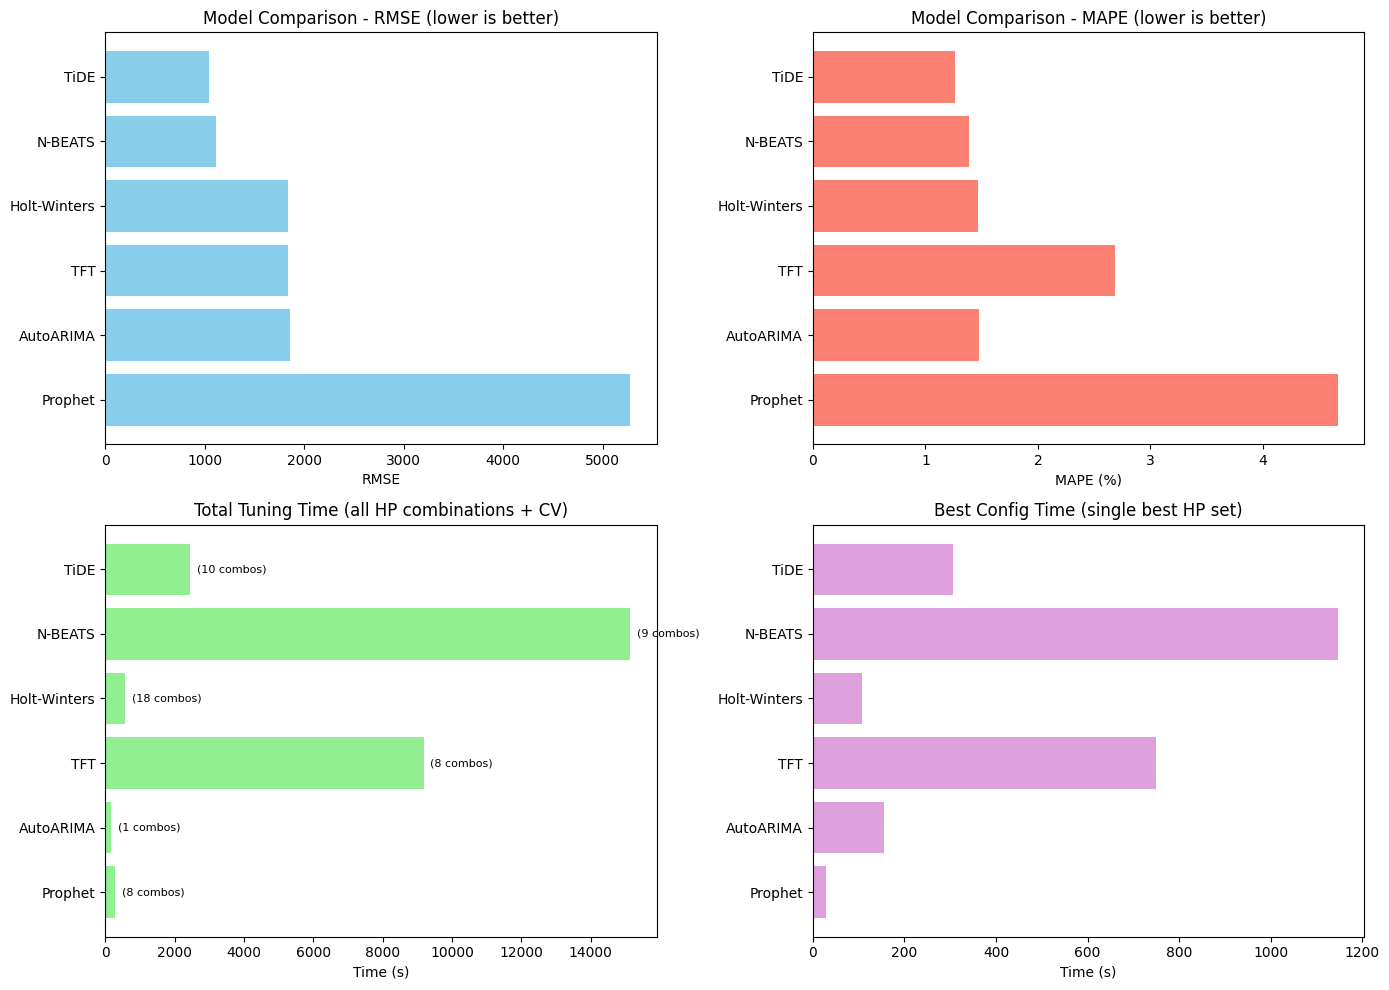


=== Summary ===
Best RMSE: TiDE (1043.4908)
Best MAPE: TiDE (1.26%)
Fastest Tuning: AutoARIMA (155.95s)
Fastest Config: Prophet (27.52s)


In [18]:
# 8. Compare Results

results_df = get_results_df()
print(results_df)

# Plot comparison with multiple metrics (RMSE, MAPE, Tuning Time, Best Config Time)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# RMSE comparison
axes[0, 0].barh(results_df['Model'], results_df['RMSE'], color='skyblue')
axes[0, 0].set_xlabel('RMSE')
axes[0, 0].set_title('Model Comparison - RMSE (lower is better)')
axes[0, 0].invert_yaxis()

# MAPE comparison
axes[0, 1].barh(results_df['Model'], results_df['MAPE'], color='salmon')
axes[0, 1].set_xlabel('MAPE (%)')
axes[0, 1].set_title('Model Comparison - MAPE (lower is better)')
axes[0, 1].invert_yaxis()

# Total Tuning Time comparison (includes all HP combinations + CV)
axes[1, 0].barh(results_df['Model'], results_df['Tuning Time (s)'], color='lightgreen')
axes[1, 0].set_xlabel('Time (s)')
axes[1, 0].set_title('Total Tuning Time (all HP combinations + CV)')
axes[1, 0].invert_yaxis()
# Add number of combinations as annotation
for i, (model, combos) in enumerate(zip(results_df['Model'], results_df['Combinations'])):
    axes[1, 0].annotate(f'({combos} combos)', xy=(results_df['Tuning Time (s)'].iloc[i], i), 
                        xytext=(5, 0), textcoords='offset points', va='center', fontsize=8)

# Best Config Time comparison (single best configuration)
axes[1, 1].barh(results_df['Model'], results_df['Best Config Time (s)'], color='plum')
axes[1, 1].set_xlabel('Time (s)')
axes[1, 1].set_title('Best Config Time (single best HP set)')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

# Summary table
print("\n=== Summary ===")
print(f"Best RMSE: {results_df.iloc[0]['Model']} ({results_df.iloc[0]['RMSE']:.4f})")
print(f"Best MAPE: {results_df.sort_values('MAPE').iloc[0]['Model']} ({results_df.sort_values('MAPE').iloc[0]['MAPE']:.2f}%)")
print(f"Fastest Tuning: {results_df.sort_values('Tuning Time (s)').iloc[0]['Model']} ({results_df.sort_values('Tuning Time (s)').iloc[0]['Tuning Time (s)']:.2f}s)")
print(f"Fastest Config: {results_df.sort_values('Best Config Time (s)').iloc[0]['Model']} ({results_df.sort_values('Best Config Time (s)').iloc[0]['Best Config Time (s)']:.2f}s)")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 78.6 K | train
6 | decoders         | Sequential       | 66.0 K | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 588    | train
--------------------------------------------------------------
145 K     Trainable params
0         Non-trainable params
145 K     Total params
0.583     Total estimated model params size (MB)
36        Modules in train mode
0         Modules in eval 

Best RMSE Model: TiDE
  - Params: {'input_chunk_length': 48, 'output_chunk_length': 12, 'n_epochs': 20, 'random_state': 42, 'hidden_size': 128, 'dropout': 0.1, 'num_encoder_layers': 2, 'num_decoder_layers': 1}
  - RMSE: 1043.4908, MAPE: 1.26%
  - Tuning time: 2438.12s (10 combinations)

Fastest Tuning Model: AutoARIMA
  - Params: {'season_length': 24, 'seasonal': True, 'max_p': 5, 'max_q': 5, 'max_P': 2, 'max_Q': 2, 'max_D': 1}
  - RMSE: 1852.5964, MAPE: 1.48%
  - Tuning time: 155.95s (1 combinations)

[Plot showing: from 2024-06-01 + test]


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

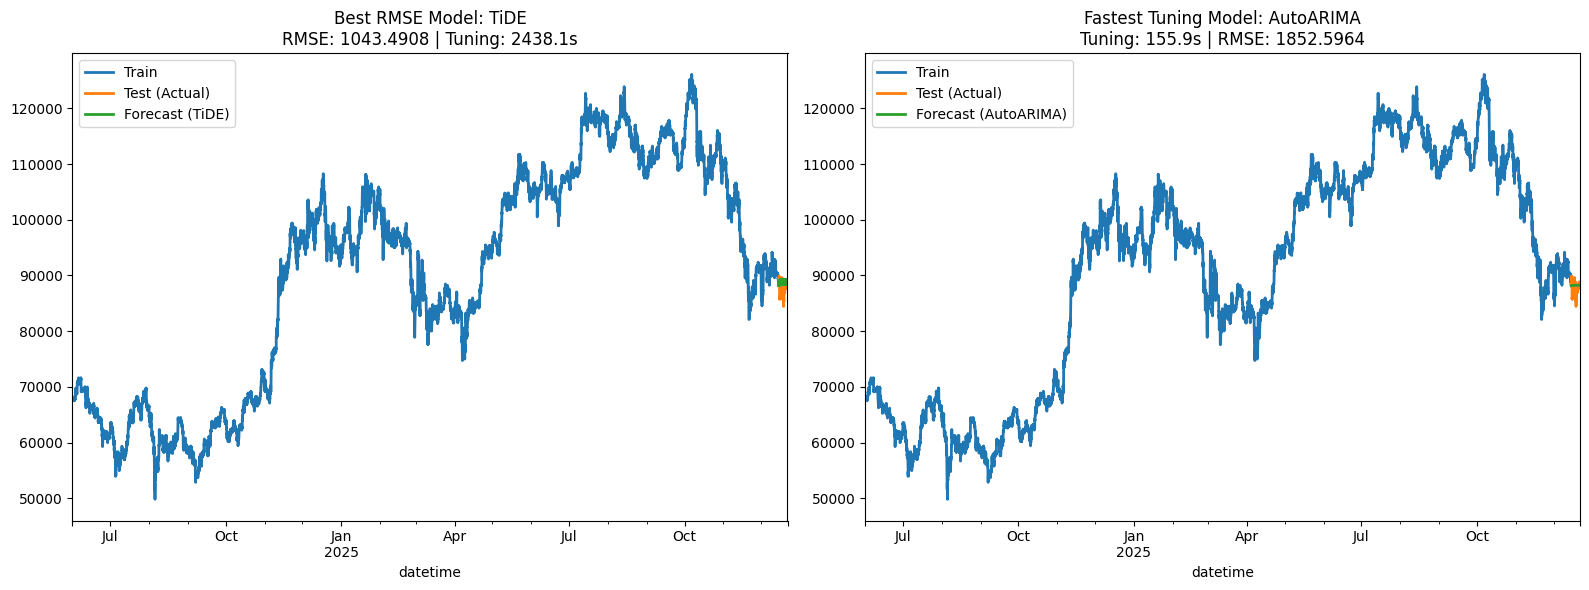

In [20]:
# 9. Final Prediction with Best Model (RMSE) and Fastest Tuning Model

# ============================================================================
# PLOT CONFIGURATION - CHANGE THIS TO ADJUST VISUALIZATION
# ============================================================================
# Options:
#   - None: show full train + test
#   - Integer (e.g., 500): show last N points of train + test
#   - String date (e.g., "2021-01-01"): show data from this date onwards
PLOT_FROM = "2024-06-01"  # <-- CHANGE THIS VALUE AND RE-RUN ONLY THIS CELL

def get_plot_slice(series, plot_from):
    """Slice series for plotting based on plot_from parameter."""
    if plot_from is None:
        return series
    elif isinstance(plot_from, int):
        # Last N points
        return series[-plot_from:] if len(series) > plot_from else series
    elif isinstance(plot_from, str):
        # From specific date
        start_time = pd.Timestamp(plot_from)
        return series.slice(start_time, series.end_time())
    return series

def train_and_predict(model_name, params, is_dl):
    """Helper function to train model and get predictions."""
    model_map = {
        "Holt-Winters": ExponentialSmoothing,
        "AutoARIMA": AutoARIMA,
        "Prophet": Prophet,
        "TiDE": TiDEModel,
        "N-BEATS": NBEATSModel,
        "TFT": TFTModel
    }
    
    if model_name not in model_map:
        return None
        
    model_cls = model_map[model_name]
    model = model_cls(**params)
    
    if is_dl:
        model.fit(train_scaled)
        pred_scaled = model.predict(len(test))
        pred = scaler.inverse_transform(pred_scaled)
    else:
        model.fit(train)
        pred = model.predict(len(test))
    
    return pred

if not results_df.empty:
    # Best model by RMSE
    best_rmse_row = results_df.iloc[0]
    best_rmse_model = best_rmse_row['Model']
    best_rmse_params = best_rmse_row['Params']
    is_dl_rmse = best_rmse_model in ["TiDE", "N-BEATS", "TFT"]
    
    # Fastest model by TOTAL TUNING TIME (fair comparison including all HP search)
    fastest_df = results_df.sort_values(by='Tuning Time (s)')
    fastest_row = fastest_df.iloc[0]
    fastest_model = fastest_row['Model']
    fastest_params = fastest_row['Params']
    is_dl_fastest = fastest_model in ["TiDE", "N-BEATS", "TFT"]
    
    print(f"Best RMSE Model: {best_rmse_model}")
    print(f"  - Params: {best_rmse_params}")
    print(f"  - RMSE: {best_rmse_row['RMSE']:.4f}, MAPE: {best_rmse_row['MAPE']:.2f}%")
    print(f"  - Tuning time: {best_rmse_row['Tuning Time (s)']:.2f}s ({best_rmse_row['Combinations']} combinations)")
    print()
    print(f"Fastest Tuning Model: {fastest_model}")
    print(f"  - Params: {fastest_params}")
    print(f"  - RMSE: {fastest_row['RMSE']:.4f}, MAPE: {fastest_row['MAPE']:.2f}%")
    print(f"  - Tuning time: {fastest_row['Tuning Time (s)']:.2f}s ({fastest_row['Combinations']} combinations)")
    print(f"\n[Plot showing: {'last ' + str(PLOT_FROM) + ' train points' if isinstance(PLOT_FROM, int) else 'from ' + PLOT_FROM if isinstance(PLOT_FROM, str) else 'full data'} + test]")
    
    # Get sliced train for plotting
    train_plot = get_plot_slice(train, PLOT_FROM)
    
    # Create predictions
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Best RMSE Model
    pred_rmse = train_and_predict(best_rmse_model, best_rmse_params, is_dl_rmse)
    if pred_rmse is not None:
        train_plot.plot(ax=axes[0], label='Train')
        test.plot(ax=axes[0], label='Test (Actual)')
        pred_rmse.plot(ax=axes[0], label=f'Forecast ({best_rmse_model})')
        axes[0].set_title(f'Best RMSE Model: {best_rmse_model}\nRMSE: {best_rmse_row["RMSE"]:.4f} | Tuning: {best_rmse_row["Tuning Time (s)"]:.1f}s')
        axes[0].legend()
    else:
        axes[0].text(0.5, 0.5, f'Model {best_rmse_model} not available', ha='center', va='center')
        axes[0].set_title('Best RMSE Model - Not Available')
    
    # Plot 2: Fastest Tuning Model
    if fastest_model == best_rmse_model:
        pred_fast = pred_rmse
    else:
        pred_fast = train_and_predict(fastest_model, fastest_params, is_dl_fastest)
    
    if pred_fast is not None:
        train_plot.plot(ax=axes[1], label='Train')
        test.plot(ax=axes[1], label='Test (Actual)')
        pred_fast.plot(ax=axes[1], label=f'Forecast ({fastest_model})')
        axes[1].set_title(f'Fastest Tuning Model: {fastest_model}\nTuning: {fastest_row["Tuning Time (s)"]:.1f}s | RMSE: {fastest_row["RMSE"]:.4f}')
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, f'Model {fastest_model} not available', ha='center', va='center')
        axes[1].set_title('Fastest Model - Not Available')
    
    plt.tight_layout()
    plt.show()
else:
    print("No results to display.")